<a href="https://colab.research.google.com/github/100jy/lstm_com/blob/master/%EC%8B%9C%EA%B3%84%EC%97%B4_%EC%98%88%EC%B8%A1_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import Dataset
import torch.optim.adam
import datetime
import matplotlib.pyplot as plt 
from tqdm import tqdm

# feature 생성

In [857]:

train = pd.read_csv("./drive/MyDrive/데이콘/train.csv", encoding = 'euc-kr')

# 시간 관련 변수들
train['DateTime'] = pd.to_datetime(train.DateTime)
train['Date'] = train.DateTime.dt.date
train['DayOfWeek'] = (train.DateTime.dt.weekday)/6

train['DayOfMon'] = ((train.DateTime).dt.day)/31
train['Days'] = (train.DateTime.max() - train.DateTime).dt.days + 1
right = train.iloc[:,5:].groupby(train['Date']).mean().reset_index()
train  = pd.merge(left, right, on='Date')

def log_trans(x):
  return np.log(1+x)
  #return np.sqrt(x)

train['Days'] = log_trans(train['Days'])


# ts feature 생성 
for target in ['사용자', '세션', '신규방문자', '페이지뷰']:
    train[f'{target}CumSum'] = train[target].cumsum()
    
    for dow in range(7):
        train[f'{target}DOW{dow}'] = ((train.DayOfWeek == dow) * train[target]).cumsum() / (train[target].cumsum() + 1)
    
    for k in [3,7,14,21]:
        train[f'{target}RollingMean{k}'] =  log_trans(train[target].rolling(k).mean())

    train[f'{target}RollingStd21'] =  log_trans(train[target].rolling(21).std().round(0))
    train[f'{target}DaysSince10000'] = (train[f'{target}CumSum'] > 10000) * 1
    train[f'{target}DaysSince100000'] = (train[f'{target}CumSum'] > 100000) * 1

    train[f'{target}RollingMeanDiff2w'] = train[f'{target}RollingMean7'] / (train[f'{target}RollingMean14'] + 1) - 1
    train[f'{target}RollingMeanDiff3w'] = train[f'{target}RollingMean7'] / (train[f'{target}RollingMean21'] + 1) - 1


    train[f'{target}CumSum'] = log_trans(train[target].cumsum())
    train[target] = log_trans(train[target])
    
train = train.dropna()

In [858]:
train

,Date,사용자,세션,신규방문자,페이지뷰,DayOfWeek,DayOfMon,Days,사용자CumSum,사용자DOW0,사용자DOW1,사용자DOW2,사용자DOW3,사용자DOW4,사용자DOW5,사용자DOW6,사용자RollingMean3,사용자RollingMean7,사용자RollingMean14,사용자RollingMean21,사용자RollingStd21,사용자DaysSince10000,사용자DaysSince100000,사용자RollingMeanDiff2w,사용자RollingMeanDiff3w,세션CumSum,세션DOW0,세션DOW1,세션DOW2,세션DOW3,세션DOW4,세션DOW5,세션DOW6,세션RollingMean3,세션RollingMean7,세션RollingMean14,세션RollingMean21,세션RollingStd21,세션DaysSince10000,세션DaysSince100000,세션RollingMeanDiff2w,세션RollingMeanDiff3w,신규방문자CumSum,신규방문자DOW0,신규방문자DOW1,신규방문자DOW2,신규방문자DOW3,신규방문자DOW4,신규방문자DOW5,신규방문자DOW6,신규방문자RollingMean3,신규방문자RollingMean7,신규방문자RollingMean14,신규방문자RollingMean21,신규방문자RollingStd21,신규방문자DaysSince10000,신규방문자DaysSince100000,신규방문자RollingMeanDiff2w,신규방문자RollingMeanDiff3w,페이지뷰CumSum,페이지뷰DOW0,페이지뷰DOW1,페이지뷰DOW2,페이지뷰DOW3,페이지뷰DOW4,페이지뷰DOW5,페이지뷰DOW6,페이지뷰RollingMean3,페이지뷰RollingMean7,페이지뷰RollingMean14,페이지뷰RollingMean21,페이지뷰RollingStd21,페이지뷰DaysSince10000,페이지뷰DaysSince100000,페이지뷰RollingMeanDiff2w,페이지뷰RollingMeanDiff3w
20,2018-09-29,4.605170,4.564348,3.258097,5.937536,0.833333,0.935484,6.650279,8.488999,0.147295,0.132483,0.0,0.0,0.0,0.0,0.0,4.897840,4.922064,5.287184,5.448583,4.465908,0,0,-0.217127,-0.236722,8.429236,0.143263,0.134964,0.0,0.0,0.0,0.0,0.0,4.852030,4.875197,5.231491,5.389072,4.382027,0,0,-0.217651,-0.236947,6.887553,0.141837,0.141837,0.0,0.0,0.0,0.0,0.0,3.545779,3.352407,3.789048,3.863233,3.044522,0,0,-0.299985,-0.310663,10.466327,0.166491,0.123601,0.0,0.0,0.0,0.0,0.0,6.511250,6.629552,7.164776,7.422374,6.869014,1,0,-0.188030,-0.212864
21,2018-09-30,4.804021,4.770685,4.110874,6.068426,1.000000,0.967742,6.648985,8.513587,0.143717,0.153553,0.0,0.0,0.0,0.0,0.0,4.747826,4.879550,5.257495,5.415253,4.488636,0,0,-0.220207,-0.239383,8.454466,0.139693,0.156516,0.0,0.0,0.0,0.0,0.0,4.709530,4.831736,5.200862,5.356137,4.406719,0,0,-0.220796,-0.239831,6.946976,0.133654,0.191346,0.0,0.0,0.0,0.0,0.0,3.697178,3.465736,3.836375,3.850148,2.995732,0,0,-0.283402,-0.285437,10.478527,0.164472,0.134228,0.0,0.0,0.0,0.0,0.0,6.191681,6.507064,7.105552,7.381858,6.905753,1,0,-0.197209,-0.223673
22,2018-10-01,4.718499,4.709530,3.583519,6.016157,0.000000,0.032258,6.647688,8.535622,0.162380,0.150206,0.0,0.0,0.0,0.0,0.0,4.712529,4.868633,5.172106,5.382308,4.521789,0,0,-0.211188,-0.237167,8.477620,0.159384,0.152934,0.0,0.0,0.0,0.0,0.0,4.685213,4.835147,5.122262,5.324867,4.430817,0,0,-0.210235,-0.235534,6.980076,0.161860,0.185116,0.0,0.0,0.0,0.0,0.0,3.713572,3.534729,3.782565,3.833804,2.995732,0,0,-0.260914,-0.268748,10.489968,0.173977,0.132701,0.0,0.0,0.0,0.0,0.0,6.008813,6.450696,6.934745,7.330686,6.932448,1,0,-0.187032,-0.225670
23,2018-10-02,4.634729,4.564348,3.332205,6.150603,0.166667,0.064516,6.646391,8.555452,0.159192,0.147257,0.0,0.0,0.0,0.0,0.0,4.721471,4.857595,5.073834,5.331338,4.521789,0,0,-0.200242,-0.232770,8.497195,0.156295,0.149969,0.0,0.0,0.0,0.0,0.0,4.685213,4.816819,5.024820,5.273732,4.430817,0,0,-0.200504,-0.232224,7.004882,0.157895,0.180581,0.0,0.0,0.0,0.0,0.0,3.729701,3.583519,3.706579,3.801357,2.995732,0,0,-0.238615,-0.253645,10.502901,0.171742,0.130996,0.0,0.0,0.0,0.0,0.0,6.079933,6.437980,6.768822,7.281779,6.950815,1,0,-0.171305,-0.222633
24,2018-10-03,4.477337,4.442651,3.496508,5.953243,0.333333,0.096774,6.645091,8.572060,0.156569,0.144832,0.0,0.0,0.0,0.0,0.0,4.615121,4.771895,5.002507,5.281026,4.521789,0,0,-0.205016,-0.240268,8.514189,0.153661,0.147442,0.0,0.0,0.0,0.0,0.0,4.578142,4.731173,4.958841,5.222927,4.430817,0,0,-0.206025,-0.239719,7.033506,0.153439,0.175485,0.0,0.0,0.0,0.0,0.0,3.476099,3.622434,3.697768,3.787431,2.995732,0,0,-0.228903,-0.243345,10.513389,0.169950,0.129629,0.0,0.0,0.0,0.0,0.0,6.043424,6.273955,6.664409,7.206589,6.941190,1,0,-0.181417,-0.235498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [831]:
def make_data(df, window_size=61):
  # in 61
  input_window = window_size
  # out 61 
  output_window = 61

  window_x = np.zeros((df.shape[0] - (input_window + output_window), input_window, df.shape[1]-1))
  window_y = np.zeros((df.shape[0] - (input_window + output_window), output_window, 4))

  for start in range(df.shape[0] - (input_window + output_window)):
      end = start + input_window    
      window_x[start,:, :] = df.iloc[start : end, 1: ].values
      window_y[start,:, :] = df.iloc[end   : end + output_window, 1: 5].values


  return window_x, window_y

In [859]:
x,y = make_data(train)
x.shape, y.shape

((650, 61, 75), (650, 61, 4))

In [786]:
class DatasetWindows(Dataset):
  def __init__(self, df):
    x, y = make_data(df)
    self.x = torch.tensor(x, dtype=torch.float32).cuda()
    self.y = torch.tensor(y, dtype=torch.float32).cuda()
    
  def __len__(self):
    return len(self.x)
    
  def __getitem__(self, idx):
    return self.x[idx,...], self.y[idx,...]

# model

In [865]:
# in 61 out 61일
# B x 61 x 75
# embedding
# B x 61 x 4
# recurrent
# B x 61 x 4
class SimpleLinear(nn.Module):
    def __init__(self):
        super(SimpleLinear, self).__init__()

        self.embedding = nn.Sequential(nn.Linear(75, 32),
                                       nn.Dropout(0.8),
                                       nn.ReLU())
        self.last = nn.Sequential(nn.Linear(32, 4))
    
    def forward(self, x_time):
        x_time = self.embedding(x_time)
        out_time = self.last(x_time)
        
        return out_time

In [861]:
class ModelManager():
  def __init__(self, model_name, df, device='gpu', cv=50):
    super(ModelManager, self).__init__()
    self.cv = cv
    # CV 구현..
    self.models = []
    self.dataloders = []
    
    for i in range(cv):  
      model =  model_name()
      if device == 'gpu':
        model =  model.cuda()
      self.models.append(model)

      cv_set = df
      dataset = DatasetWindows(cv_set)
      self.dataloders.append(DataLoader(dataset, batch_size=300,  num_workers=0, pin_memory=False,
                                        shuffle=True))
    
  def fit(self, num_epochs=500, lr=1e-2 ,log=False, val_set=None, train_set=None):
    
    def get_val_loss():
      val_loss = self.make_val_plot(val_set, train_set, get_loss=True)
      return val_loss

    for i in tqdm(range(self.cv)):  
      # Train model
      model = self.models[i]
      dataloader = self.dataloders[i]
      optimizer = torch.optim.Adam(model.parameters(), lr=lr)
      criterion = nn.MSELoss(size_average = True)

      for epoch in range(num_epochs):
          for data in dataloader:
              x, y = data
              train_pred = model(x)
              loss = criterion(train_pred, y)
              optimizer.zero_grad()
              loss.backward()
              optimizer.step()
          if epoch % 100 == 99:
            if log:
              if val_set.any().any():
                val_loss = get_val_loss()
                print(f"{epoch+1} Epochs train MSE: {loss.item():1.5f}, ", f"{epoch+1} Epochs val MSE: {val_loss:1.5f}")
              else: 
                print(f"{epoch+1} Epochs train MSE: {loss.item():1.5f}")


  @staticmethod
  def inverse_log(x):
    # 32bit 사용시 단위문제 발생..
    return (np.exp(x)-1).astype(np.int64)
    #return np.square(x).astype(np.int64)

  def predict(self, df):

    last_observe = df.iloc[-61:,1:]
    inp_tensor = torch.tensor(last_observe.values, dtype=torch.float32).cuda()
    inp_tensor = inp_tensor.unsqueeze(0)

    model = self.models[0].eval()
    prediction = model(inp_tensor)
    self.models[0] = model.train()

    for i in range(1, self.cv): 
      model = self.models[i].eval()
      prediction += model(inp_tensor)
      self.models[i] = model.train()
    
    prediction /= self.cv
    return  self.inverse_log(prediction.cpu().detach().squeeze().numpy())

  def make_val_plot(self, val_df, train_df, get_loss=False):
    #predict
    pred = self.predict(train_df)
    label = self.inverse_log(val_df)

    def dacon_rmse(true, pred):  
      w0 = 1095.214646
      w1 = 1086.728535
      w2 = 268.070707
      w3 = 24236.194444

      score = (np.sqrt(np.mean(np.square(true[:,0] - pred[:,0]))) / w0 + 
               np.sqrt(np.mean(np.square(true[:,1] - pred[:,1]))) / w1 + 
               np.sqrt(np.mean(np.square(true[:,2] - pred[:,2]))) / w2 + 
               np.sqrt(np.mean(np.square(true[:,3] - pred[:,3]))) / w3  )
      return score

    if get_loss:
      return dacon_rmse(label.values, pred)

    for idx, key in enumerate(val_df.columns):
      plt.plot(figsize=(20,10))
      plt.plot(label.index,pred[:,idx])
      plt.plot(label[key])
      plt.legend(['predict', 'label'])
      plt.show()
      
    loss = dacon_rmse(label.iloc[:,:4].values, pred)
    print('RMSE : ' + str(loss))

In [866]:
# train val split
train_whole = train
train_split = train[:-61]
val = train.iloc[-61:, 1:5]

simple = ModelManager(SimpleLinear, train_split, cv=1)
simple.fit(num_epochs=1000, lr=1e-2, log=True, val_set=val, train_set=train_split)





















  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


100 Epochs train MSE: 9.24726,  100 Epochs val MSE: 8.59247
200 Epochs train MSE: 5.30074,  200 Epochs val MSE: 7.63744
300 Epochs train MSE: 2.96970,  300 Epochs val MSE: 6.50294
400 Epochs train MSE: 1.68876,  400 Epochs val MSE: 5.98698
500 Epochs train MSE: 1.10478,  500 Epochs val MSE: 4.71258
600 Epochs train MSE: 0.76598,  600 Epochs val MSE: 3.93794
700 Epochs train MSE: 0.64218,  700 Epochs val MSE: 3.50536
800 Epochs train MSE: 0.65384,  800 Epochs val MSE: 3.55605
900 Epochs train MSE: 0.66455,  900 Epochs val MSE: 3.67056






















100%|██████████| 1/1 [00:07<00:00,  7.57s/it]

1000 Epochs train MSE: 0.64426,  1000 Epochs val MSE: 3.45317


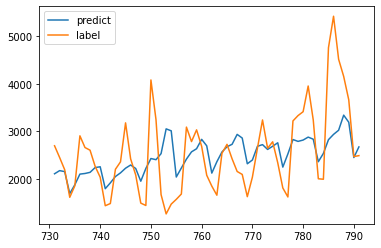

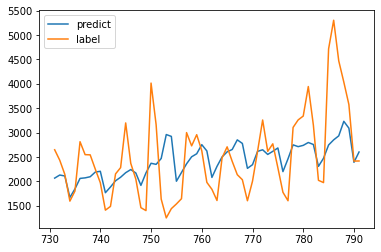

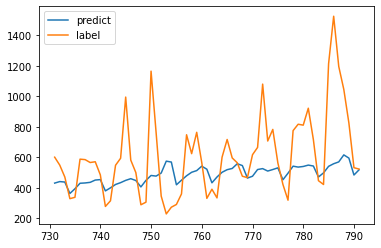

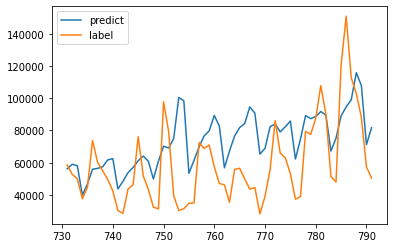

RMSE : 3.453172860861545


In [867]:
simple.make_val_plot(val, train_split)

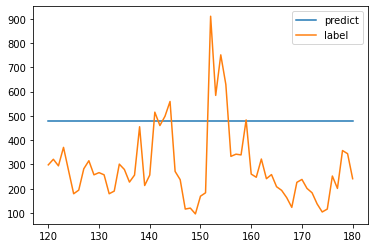

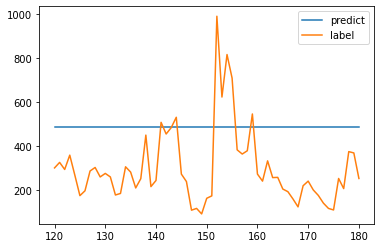

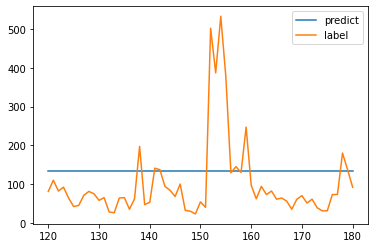

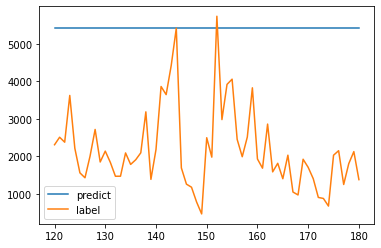

RMSE : 0.9947454653814927


In [868]:
simple.make_val_plot( train_split.iloc[100:100 + 61, 1:5], train_split[:100])

In [772]:
predictor = ModelManager(SimpleLinear, train_whole, cv=1)
predictor.fit(num_epochs=300, lr=1e-2, log=False)














  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))













100%|██████████| 1/1 [00:11<00:00, 11.44s/it]


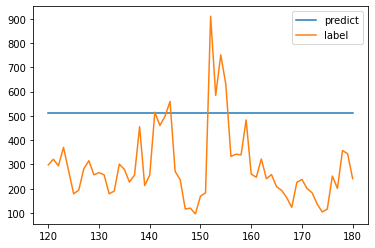

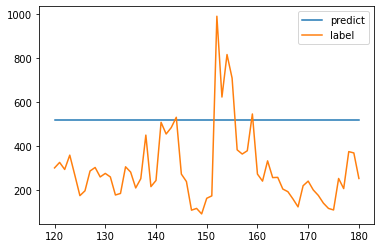

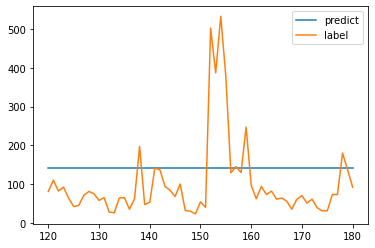

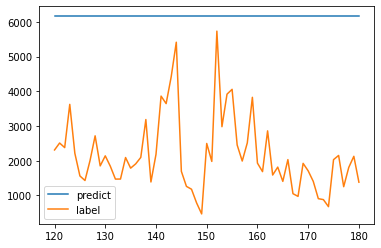

RMSE : 1.0795827842715422


In [780]:
predictor.make_val_plot( train_split.iloc[100:100 + 61, 1:5], train_split[:100])

In [750]:
submission = pd.read_csv("./drive/MyDrive/데이콘/submission.csv", encoding = 'euc-kr') 
submission.iloc[:,1:] = predictor.predict(train_whole)
submission.to_csv('submission.csv', index = False, encoding = 'euc-kr')
print(submission)
print('saved result')

      DateTime   사용자    세션  신규방문자    페이지뷰
0   2020-11-09  1965  1931    422   47013
1   2020-11-10  2015  1979    431   48855
2   2020-11-11  2070  2032    440   50905
3   2020-11-12  2132  2091    451   53254
4   2020-11-13  2087  2048    443   51554
..         ...   ...   ...    ...     ...
56  2021-01-04  3995  3862    751  139240
57  2021-01-05  4317  4168    800  156836
58  2021-01-06  4586  4422    840  172073
59  2021-01-07  5052  4863    909  199609
60  2021-01-08  5404  5194    960  221281

[61 rows x 5 columns]
saved result
